In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from scipy.optimize import minimize

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta + 1 * np.random.normal(0, 5)
        quantity_list.append(quantity)
    # print("quantity_list", quantity_list)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [4]:
# 目的関数を定義（最大化問題を最小化問題に変換）
def sales_objective_function(prices, alpha, beta, M):
    return -sum(
        prices[m] * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )

In [5]:
# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_prices,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="SLSQP",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [6]:
def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(
        sales_objective_function,
        initial_prices,
        args=(alpha, beta, M),
        bounds=bounds,
        method="SLSQP",
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [7]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(
            predict_objective_function,
            initial_prices,
            args=(intercepts, coefs, M),
            bounds=bounds,
            method="SLSQP",
        )
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [8]:
# このデータにおけるalpha,betaを作成
M = 20
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)

z = [0.6, 0.7, 0.8, 0.9, 1.0]

# 予測と最適化を行う関数
optimal_value, optimal_prices = predict_optimize(M, X, y, z)

# salesと最適化を行う関数
optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)

# optimal_prices = np.round(optimal_prices, 1)をsales_functionに入れて売上を計算
sales = sum(sales_function(optimal_prices, alpha, beta))

# cvを行う関数
cv = cross_validation(X, y, M, 5, z)

print("optimal_prices", optimal_prices)
print("optimal_value", optimal_value)
print("optimal_prices_sales", optimal_prices_sales)
print("optimal_value_sales", optimal_value_sales)
print("cv", cv)
print("sales", sales)

optimal_prices [1.         1.         0.94400474 1.         0.98774084 1.
 0.6        1.         0.6806623  1.         1.         1.
 0.92717981 0.82059302 0.91337756 0.78813497 0.75758049 0.91069065
 0.78786336 1.        ]
optimal_value 383.5817409785676
optimal_prices_sales [0.74413899 1.         0.93792548 1.         0.97540726 1.
 0.6        0.94424413 0.70070609 0.97795306 1.         1.
 0.71947415 0.71727316 0.86071182 0.73616705 0.85237193 0.86775598
 0.73974069 0.86610285]
optimal_value_sales 370.2504848458398
cv 374.52531755516276
sales 365.62409956354213


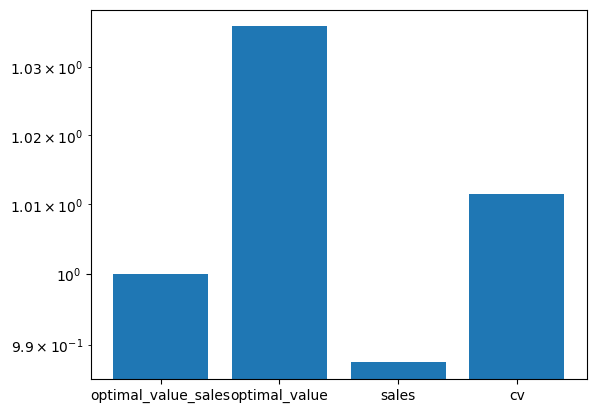

In [9]:
# 結果を棒グラフで表示

# データの準備
labels = ["optimal_value_sales", "optimal_value", "sales", "cv"]
values = [
    optimal_value_sales / optimal_value_sales,
    optimal_value / optimal_value_sales,
    sales / optimal_value_sales,
    cv / optimal_value_sales,
]

# グラフの描画
plt.bar(labels, values)

# logスケールに設定
plt.yscale("log")

# グラフの表示
plt.show()

In [20]:
# M=20で100回実行し、平均をプロット
M = 20

# listを作成
optimal_value_list = []
optimal_value_sales_list = []
cv_list = []
price_sales_list = []
for i in range(100):
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    price_list = []
    sales_list = []

    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    optimal_value, optimal_prices = predict_optimize(M, X, y, z)
    optimal_value_sales, optimal_prices_sales = sales_optimize(M, alpha, beta, z)
    price_sales = sum(sales_function(optimal_prices, alpha, beta))
    cv = cross_validation(X, y, M, 5, z)

    print(price_sales)

    optimal_value_sales_list.append(optimal_value_sales / optimal_value_sales)
    optimal_value_list.append(optimal_value / optimal_value_sales)
    cv_list.append(cv / optimal_value_sales)
    price_sales_list.append(price_sales / optimal_value_sales)

# 結果を棒グラフで表示
print(sales_list)
# データの準備

363.7100860513133
372.91470615427295
387.83521671826696
469.3621390271658
441.45487150953164
453.67747528553684
436.07188328837134
389.6359095764636
465.9970189186848
338.9502015965409
369.3702599398138
362.1448613205351
428.76139329913053
374.8151697914289
441.26499555267225
446.018746959633
474.88309123014346
333.72176987217136
341.57937323815696
411.44749448993895
396.12124850921555
377.6790221436784
410.8090265820717
386.84496752305705
376.7284381028014
397.9601400457818
412.0252639341808
379.97614954474045
359.116272234337
428.9616243158412
442.81890026381103
389.94126541937044
394.889620777904
372.7624098231753
481.88982728201034
374.9630903868897
327.6521607851482
408.8930122123072
366.74811080502894
462.912112197969
436.3324652508284
428.52566021420085
422.59283137612863
468.8643186107326
432.4977469772395
450.0108229625761
378.57241421208886
359.55216364943186
325.4003861853461
476.18498977946496
397.63555898621064
441.73848701276796
340.0955844318671
410.67844215838846
376.80

In [22]:
len(price_sales_list)

100

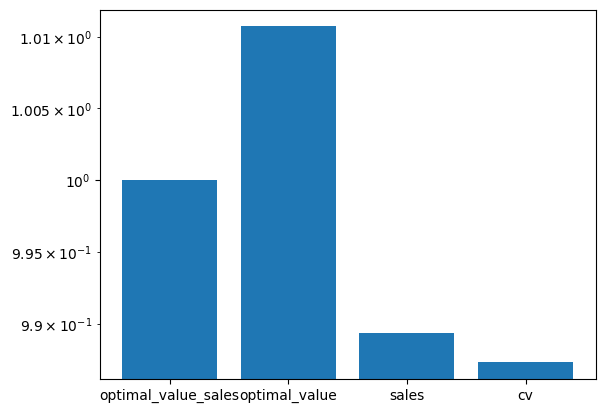

In [23]:
labels = ["optimal_value_sales", "optimal_value", "sales", "cv"]
values = [
    np.mean(optimal_value_sales_list),
    np.mean(optimal_value_list),
    np.mean(price_sales_list),
    np.mean(cv_list),
]

# グラフの描画
plt.bar(labels, values)

# logスケールに設定
plt.yscale("log")

# グラフの表示
plt.show()
